# Lab 6: Supervised learning (graded)

Sensor dataset (dumbbell biceps curl, classes A–E). Goal: clean data, reduce dimensionality keeping 99% variance, and compare single classifiers and ensembles targeting F1>90%.

_Note: requires `pandas`, `scikit-learn`, `matplotlib` installed._

## Plan
- Load and clean `ds_01.csv` (drop identifiers/timestamps, replace NA markers, coerce to numeric).
- Drop columns with many NAs (high threshold) plus fixed lists (100% NA, zero variance); keep a stable feature list.
- Common pipeline: imputation (median) + standard scaling + PCA (99% variance).
- Single models (4 from previous labs): SVC RBF, Logistic Regression, Decision Tree, Perceptron.
- Ensembles (4): Voting (soft), Bagging (tree base), RandomForest, ExtraTrees. Compare with `f1_macro` via stratified CV.
- Pick best single and best ensemble; show confusion matrix and accuracy with `cross_val_predict`.
- Fit best ensemble on full data and predict `common.csv`; if ground truth is available, report metrics; otherwise, show predictions only.


## Dataset summary
- Rows: 9,811; columns: 160; classes A–E with distribution A 2790, B 1899, C 1711, D 1608, E 1803.
- Columns with 100% NA: `kurtosis_yaw_belt`, `skewness_yaw_belt`, `kurtosis_yaw_dumbbell`, `skewness_yaw_dumbbell`, `kurtosis_yaw_forearm`, `skewness_yaw_forearm`; ~98.6% NA in several forearm/arm cols (e.g., `kurtosis_picth_forearm`, `skewness_pitch_forearm`).
- Non-numeric columns: `user_name`, `cvtd_timestamp`, `new_window`; the rest mostly numeric after coercion.
- Index column `Unnamed: 0` has no predictive value.


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier, StackingClassifier
import matplotlib.pyplot as plt

# reproducibility
RANDOM_STATE = 42

## Data loading and cleaning

In [2]:
data_path = Path('./ds_01.csv')
common_path = Path('./common.csv')

# columnas de identificación/tiempo que no aportan a la predicción
meta_cols = ["user_name", "raw_timestamp_part_1", "raw_timestamp_part_2", "cvtd_timestamp", "new_window", "num_window", "Unnamed: 0", ""]

# columnas a eliminar siempre (sin depender del cálculo en runtime)
na_100_cols = [
    "kurtosis_yaw_belt", "skewness_yaw_belt", "kurtosis_yaw_dumbbell", "skewness_yaw_dumbbell",
    "kurtosis_yaw_forearm", "skewness_yaw_forearm",
]
zero_var_cols = ["amplitude_yaw_belt", "amplitude_yaw_dumbbell", "amplitude_yaw_forearm"]

missing_tokens = {"", 'nan', 'NA', '#DIV/0!', 'NaN', 'N/A'}
NA_THRESHOLD = 0.95  # umbral alto de NA para descartar columnas

def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]
    df.replace(missing_tokens, np.nan, inplace=True)
    if '' in df.columns:
        df = df.drop(columns=[''])
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    return df

def split_features_labels(df: pd.DataFrame):
    y = df['class']
    X = df.drop(columns=['class'])
    drop_cols = [c for c in meta_cols if c in X.columns]
    X = X.drop(columns=drop_cols)
    X = X.apply(pd.to_numeric, errors='coerce')
    # drop explícito de columnas 100% NA y varianza cero conocidas
    X = X.drop(columns=[c for c in na_100_cols if c in X.columns], errors='ignore')
    X = X.drop(columns=[c for c in zero_var_cols if c in X.columns], errors='ignore')
    return X, y

# carga inicial
raw_df = clean_dataframe(pd.read_csv(data_path))
X_raw, y = split_features_labels(raw_df)
# trabajar siempre con copias para no tocar los dataframes originales
X_work = X_raw.copy(deep=True)
y_work = y.copy(deep=True)

# resumen rápido
print(f"Filas={len(raw_df)}, Columnas={raw_df.shape[1]}")
print(f"Clases: {y.value_counts().to_dict()}")

# eliminación de columnas con muchos NAs (> NA_THRESHOLD)
na_ratio = X_work.isna().mean()
high_na_cols = na_ratio[na_ratio > NA_THRESHOLD].index.tolist()
if high_na_cols:
    print(f"Drop por NA (>{NA_THRESHOLD*100:.0f}%): {len(high_na_cols)} columnas")
    X_work = X_work.drop(columns=high_na_cols)
else:
    print("No se detectaron columnas con NA por encima del umbral")

print('Top 10 columnas con NA:')
print(na_ratio.sort_values(ascending=False).head(10))

feature_columns = X_work.columns
print(f"X shape tras limpieza: {X_work.shape}")


Filas=9811, Columnas=159
Clases: {'A': 2790, 'B': 1899, 'E': 1803, 'C': 1711, 'D': 1608}
Drop por NA (>95%): 91 columnas
Top 10 columnas con NA:
kurtosis_picth_forearm    0.986240
skewness_pitch_forearm    0.986240
kurtosis_roll_forearm     0.986138
max_yaw_forearm           0.986138
min_yaw_forearm           0.986138
skewness_roll_forearm     0.986036
skewness_pitch_arm        0.985934
kurtosis_picth_arm        0.985934
kurtosis_roll_arm         0.985832
skewness_roll_arm         0.985730
dtype: float64
X shape tras limpieza: (9811, 52)


### Outlier detection (optional)
The handout suggests filtering outliers. A light IsolationForest filter is provided and disabled by default to avoid data leakage; enable only if needed and document the removal rate.


In [3]:
from sklearn.ensemble import IsolationForest

APPLY_OUTLIER_FILTER = False  # pon a True si quieres filtrar antes del CV
OUTLIER_CONTAM = 0.02         # 2% de contaminación esperada

if APPLY_OUTLIER_FILTER:
    iso = IsolationForest(contamination=OUTLIER_CONTAM, random_state=RANDOM_STATE)
    mask = iso.fit_predict(X_work)
    keep = mask == 1
    print(f"Filtrando outliers: {keep.sum()} de {len(mask)} muestras conservadas")
    X_work = X_work.loc[keep].reset_index(drop=True)
    y_work = y_work.loc[keep].reset_index(drop=True)


### Common pipeline: imputation + scaling + PCA (99% variance)

In [4]:
def build_preprocess():
    return Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.99, random_state=RANDOM_STATE)),
    ])

preprocess = build_preprocess()

# ajustar una vez para conocer nr de componentes
pca_probe = preprocess.fit(X_work)
pca_n = pca_probe.named_steps['pca'].n_components_
print(f"Componentes retenidos para 99% varianza: {pca_n}")


Componentes retenidos para 99% varianza: 36


## Hyperparameter search
The handout requires describing models/hyperparameters. These grids explore reasonable values and are evaluated with macro F1 in stratified CV.


In [5]:
from sklearn.model_selection import GridSearchCV

single_param_grids = {
    'svc_rbf': {
        'clf__C': [1, 10, 50],
        'clf__gamma': ['scale', 0.01, 0.001],
    },
    'logreg': {
        'clf__C': [0.5, 1, 5, 10],
        'clf__penalty': ['l2'],
        'clf__multi_class': ['auto'],
    },
    'decision_tree': {
        'clf__max_depth': [None, 10, 20],
        'clf__min_samples_leaf': [1, 2, 4],
    },
    'perceptron': {
        'clf__alpha': [0.0001, 0.001, 0.01],
        'clf__penalty': [None, 'l2'],
    },
}

ensemble_param_grids = {
    'voting_soft': {
        # Ajustar estimadores internos si se desea
    },
    'bagging_tree': {
        'clf__n_estimators': [50, 100, 200],
        'clf__estimator__max_depth': [None, 10, 20],
    },
    'random_forest': {
        'clf__n_estimators': [150, 300],
        'clf__max_depth': [None, 15, 25],
        'clf__min_samples_leaf': [1, 2, 4],
    },
    'extra_trees': {
        'clf__n_estimators': [150, 300],
        'clf__max_depth': [None, 15, 25],
        'clf__min_samples_leaf': [1, 2, 4],
    },
}


def run_grid_search(model_name, estimator, param_grid):
    pipe = Pipeline([
        ('prep', build_preprocess()),
        ('clf', estimator),
    ])
    gs = GridSearchCV(pipe, param_grid=param_grid, scoring='f1_macro', cv=cv, n_jobs=-1)
    gs.fit(X_work, y_work)
    return gs

# Ejemplo de uso (ejecutar manualmente cuando quieras explorar):
# gs_svc = run_grid_search('svc_rbf', single_models['svc_rbf'], single_param_grids['svc_rbf'])
# print(gs_svc.best_params_, gs_svc.best_score_)


## Model definitions

## Required results (handout)
- Table of single-classifier runs (model, hyperparameters tried, mean/std F1 in CV).
- Table of ensemble runs with their F1.
- For the best single and the best ensemble: use `cross_val_predict` to get confusion matrix and accuracy.


In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Modelos individuales basados en labs previos
single_models = {
    'svc_rbf': SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced', random_state=RANDOM_STATE),  # lab1
    'logreg': LogisticRegression(max_iter=400, n_jobs=-1, class_weight='balanced', random_state=RANDOM_STATE),  # lab4
    'decision_tree': DecisionTreeClassifier(random_state=RANDOM_STATE),  # lab5
    'perceptron': Perceptron(max_iter=1000, random_state=RANDOM_STATE),  # lab3
}

# Ensembles (4 opciones)
ensemble_models = {
    'voting_soft': VotingClassifier(
        estimators=[
            ('svc', SVC(kernel='rbf', C=10, gamma='scale', probability=True, class_weight='balanced', random_state=RANDOM_STATE)),
            ('dt', DecisionTreeClassifier(random_state=RANDOM_STATE)),
            ('log', LogisticRegression(max_iter=400, n_jobs=-1, class_weight='balanced', random_state=RANDOM_STATE)),
        ],
        voting='soft'
    ),
    'bagging_tree': BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
        n_estimators=100,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'random_forest': RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        class_weight='balanced_subsample',
        random_state=RANDOM_STATE
    ),
    'extra_trees': ExtraTreesClassifier(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        class_weight='balanced',
        random_state=RANDOM_STATE
    ),
}


## Evaluation (`f1_macro`, stratified CV)

In [7]:
def evaluate_models(model_dict, X, y, cv):
    rows = []
    for name, estimator in model_dict.items():
        pipe = Pipeline([
            ('prep', build_preprocess()),
            ('clf', estimator),
        ])
        scores = cross_val_score(pipe, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)
        rows.append({'model': name, 'f1_mean': scores.mean(), 'f1_std': scores.std()})
        print(f"{name}: f1_mean={scores.mean():.4f} (+/- {scores.std():.4f})")
    return pd.DataFrame(rows).sort_values('f1_mean', ascending=False)

single_results = evaluate_models(single_models, X_work, y_work, cv)
ensemble_results = evaluate_models(ensemble_models, X_work, y_work, cv)

single_results, ensemble_results


svc_rbf: f1_mean=0.9699 (+/- 0.0028)
logreg: f1_mean=0.6261 (+/- 0.0142)
decision_tree: f1_mean=0.7849 (+/- 0.0161)
perceptron: f1_mean=0.4695 (+/- 0.0174)
voting_soft: f1_mean=0.9036 (+/- 0.0045)
bagging_tree: f1_mean=0.9385 (+/- 0.0039)
random_forest: f1_mean=0.9571 (+/- 0.0055)
extra_trees: f1_mean=0.9734 (+/- 0.0031)


(           model   f1_mean    f1_std
 0        svc_rbf  0.969876  0.002780
 2  decision_tree  0.784868  0.016105
 1         logreg  0.626137  0.014233
 3     perceptron  0.469547  0.017403,
            model   f1_mean    f1_std
 3    extra_trees  0.973436  0.003143
 2  random_forest  0.957102  0.005519
 1   bagging_tree  0.938467  0.003907
 0    voting_soft  0.903597  0.004497)

## Best single model: confusion matrix and metrics

              precision    recall  f1-score   support

           A       0.98      0.99      0.99      2790
           B       0.98      0.96      0.97      1899
           C       0.93      0.98      0.95      1711
           D       0.98      0.94      0.96      1608
           E       0.99      0.98      0.98      1803

    accuracy                           0.97      9811
   macro avg       0.97      0.97      0.97      9811
weighted avg       0.97      0.97      0.97      9811

Accuracy = 0.9718


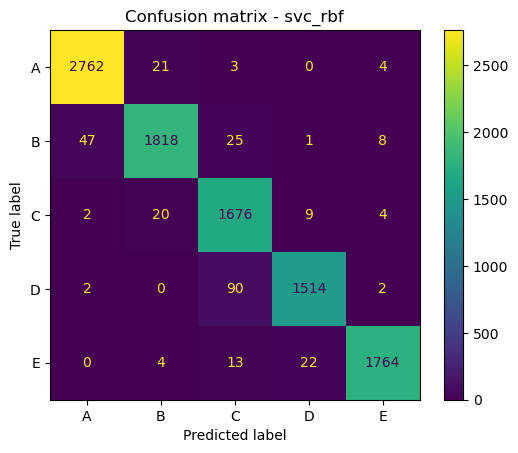

In [8]:
best_single_name = single_results.iloc[0]['model'] if not single_results.empty else None
if best_single_name:
    best_single = Pipeline([
        ('prep', build_preprocess()),
        ('clf', single_models[best_single_name]),
    ])
    y_pred_cv = cross_val_predict(best_single, X_work, y_work, cv=cv, n_jobs=-1)
    print(classification_report(y, y_pred_cv))
    print(f"Accuracy = {accuracy_score(y, y_pred_cv):.4f}")
    ConfusionMatrixDisplay.from_predictions(y, y_pred_cv)
    plt.title(f"Confusion matrix - {best_single_name}")
else:
    print("No hay resultados de modelos individuales.")


## Best ensemble: confusion matrix and metrics

              precision    recall  f1-score   support

           A       0.99      0.99      0.99      2790
           B       0.97      0.96      0.97      1899
           C       0.94      0.97      0.95      1711
           D       0.98      0.95      0.97      1608
           E       0.99      0.98      0.99      1803

    accuracy                           0.98      9811
   macro avg       0.97      0.97      0.97      9811
weighted avg       0.98      0.98      0.98      9811

Accuracy = 0.9751


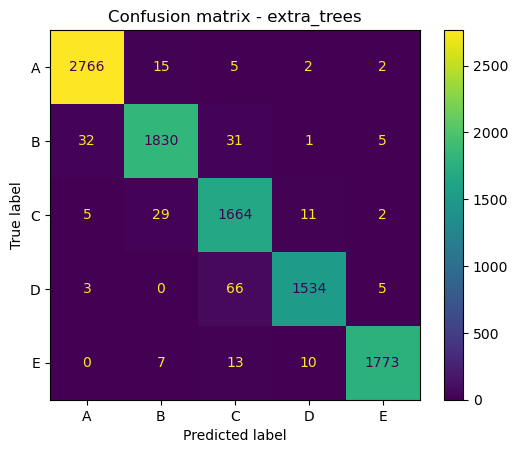

In [9]:
best_ensemble_name = ensemble_results.iloc[0]['model'] if not ensemble_results.empty else None
if best_ensemble_name:
    best_ensemble = Pipeline([
        ('prep', build_preprocess()),
        ('clf', ensemble_models[best_ensemble_name]),
    ])
    y_pred_cv = cross_val_predict(best_ensemble, X_work, y_work, cv=cv, n_jobs=-1)
    print(classification_report(y, y_pred_cv))
    print(f"Accuracy = {accuracy_score(y, y_pred_cv):.4f}")
    ConfusionMatrixDisplay.from_predictions(y, y_pred_cv)
    plt.title(f"Confusion matrix - {best_ensemble_name}")
else:
    print("No hay resultados de ensembles.")


**Note on `common.csv`:** the `class` column looks like an ID (1..20) rather than labels A–E. The code predicts A–E with the best model; if true labels exist, map them and compute confusion/accuracy, otherwise just show predictions.


## Prediction on `common.csv`
Reuse `feature_columns` and the best ensemble. If labels in `common.csv` are not in {A,B,C,D,E}, show predictions without accuracy.


              precision    recall  f1-score   support

           A       1.00      1.00      1.00         7
           B       1.00      1.00      1.00         8
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       1.00      1.00      1.00         3

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Accuracy common = 1.0000


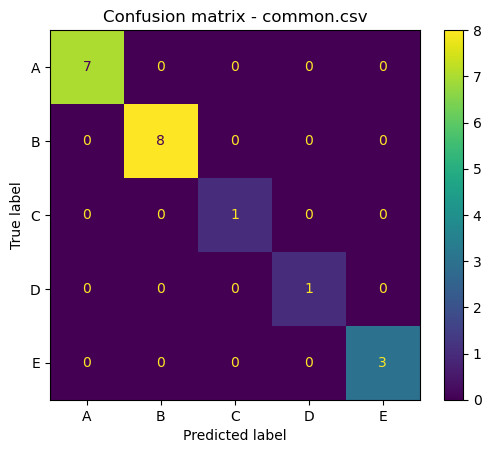

In [10]:
common_df = clean_dataframe(pd.read_csv(common_path))
X_common, y_common = split_features_labels(common_df)
# asegurar mismas columnas/orden
X_common = X_common.reindex(columns=feature_columns)

if best_ensemble_name is None:
    print("No hay ensemble entrenado.")
else:
    best_ensemble = Pipeline([
        ('prep', build_preprocess()),
        ('clf', ensemble_models[best_ensemble_name]),
    ])
    best_ensemble.fit(X_work, y_work)
    common_pred = best_ensemble.predict(X_common)
    common_df_out = pd.DataFrame({'true': y_common, 'pred': common_pred})
    if set(y_common.unique()).issubset(set(y.unique())):
        print(classification_report(y_common, common_pred))
        print(f"Accuracy common = {accuracy_score(y_common, common_pred):.4f}")
        ConfusionMatrixDisplay.from_predictions(y_common, common_pred)
        plt.title("Confusion matrix - common.csv")
    else:
        print("Las etiquetas en common.csv no coinciden con las de entrenamiento; se muestran solo predicciones:")
        print(common_df_out)
